In [1]:
import csv
import numpy as np
import logging
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_widths
import pandas as pd
from pathlib import Path

In [2]:
# This code block provides a function to read a pair of x,y numerical data columns from
# an input CSV file. It gracefully ignores all invalid lines before the first valid
# line, printing warnings if invalid lines are detected after the first valid one,
# or if no valid lines are found.
# added cutoff so you can ignore data below where peaks start (should help to avoid 1/x background)

def readCSVCleanXYthetacutoff(filename,xcol=0,ycol=1,yval=0.0,cutofflow=10.0, cutoffhigh = 60.0):
    anyValid = False
    with open(filename, "r", newline='') as f:
        rdr = csv.reader(f,delimiter=',')
        rv = []
        for l in rdr:
            try:
                rv.append([float(l[xcol]),float(l[ycol] if not (ycol is None) else yval)])
                anyValid = True
            except (ValueError, IndexError):
                if anyValid:
                    logging.warning("Invalid line %s found.", l)
    if not anyValid:
        logging.warning("No valid data found!")
    rv = np.array(rv)
    reduced = rv[rv[:,0] > cutofflow]
    reduced = reduced[reduced[:,0] < cutoffhigh]
    twotheta = reduced[:,0]
    intensity = reduced[:,1]
    return twotheta, intensity

In [3]:
#finds peaks without cif file, but may require tweaking to ensure you aren't selecting noise

def manualpeakfinder(twotheta, intensity, wlen=100, distance=25):
    peakmin=max(intensity)*0.01 #can be altered, but should keep most peaks above noise
    peaks,_ = find_peaks(intensity, prominence=peakmin, wlen=wlen, distance=distance)
    plt.plot(twotheta,intensity)
    plt.plot(twotheta[peaks], intensity[peaks], "x")
    plt.xlim(twotheta[0],twotheta[-1])
    plt.show() #sanity check for peaks
    return peaks

In [4]:
#since findpeaks takes 1D data set, need to 1) find FWHM,
#and 2) scale it back to two theta by multiplying by average distance between steps
#also makes theta so WH fitting is simpler down the line

def scaledFWHM(twotheta, intensity, peaks, zoom=(50,60)):
    theta = twotheta[peaks]/2
    FWHM = []
    results_half = peak_widths(intensity, peaks, rel_height=0.5)
    for i in range(len(peaks)): 
        width = results_half[0][i]*(np.mean(np.diff(twotheta)))
        FWHM.append(width)
    FWHM = np.asarray(FWHM)
    boolean_array = np.logical_and(twotheta >= zoom[0], twotheta <= zoom[1])
    ylim = intensity[np.where(boolean_array)[0]]
    plt.xlim(zoom) #can change, I find it useful to zoom in to see the FWHM better
    plt.ylim(0,max(ylim)*1.05)
    plt.plot(twotheta,intensity)
    plt.plot(peaks*(np.mean(np.diff(twotheta)))+twotheta[0], intensity[peaks], "x")
    plt.hlines(results_half[1],twotheta[peaks]-FWHM/2,twotheta[peaks]+FWHM/2, color="C2")
    plt.show() #sanity check for appropriate FWHM
    return theta, FWHM

In [5]:
#does the actual analysis, and converts to appropriate units

from scipy import stats
def WHfit(theta,FWHM,fname='test.csv'):
    x = np.sin(theta*(np.pi/180))
    y = np.asarray(FWHM)*(np.pi/180)*np.cos(theta*(np.pi/180)) #makes radians
    res = stats.linregress(x, y)
    plt.plot(x, y, 'o', label='original data')
    plt.plot(x, res.intercept + res.slope*x, 'r', label='fitted line')
    plt.xlabel(r'sin$\theta$')
    plt.ylabel(r'$\beta cos\theta$')
    plt.savefig(fname[0:len(fname)-4]+'WHlinearfit', bb_inches='tight') #ref plot with linear fit
    display
    return res, x, y #gives you slope (strain) and interecept (crystallite size)

In [6]:
#clears out data points that are outliers due to preferred orientation or overlapping peaks

def reject_outliers(theta,FWHM,nos=2):
    x = np.sin(theta*(np.pi/180))
    y = np.asarray(FWHM)*(np.pi/180)*np.cos(theta*(np.pi/180))
    filtered_x = []
    filtered_y = []
    u = np.mean(y)
    s = np.std(y)
    for k in range(len(y)):
        if u-nos*s < y[k] < u+nos*s:
            filtered_x.append(x[k])
            filtered_y.append(y[k])
    return np.asarray(filtered_x), np.asarray(filtered_y)

In [7]:
#Does all the above for ease, should just need to give file name
#will reject outliers only if reject=True

def manualWH(fname,reject=False,cutoff=10,nos=2, zoom=(50,60)):
    twotheta, intensity = readCSVCleanXYthetacutoff(fname)
    peaks = manualpeakfinder(twotheta, intensity)
    theta, FWHM = scaledFWHM(twotheta, intensity, peaks, xzoom)
    if reject is True:
        x, y = reject_outliers(theta,FWHM)
        res = stats.linregress(x, y)
        plt.plot(x, y, 'o', label='original data')
        plt.plot(x, res.intercept + res.slope*x, 'r', label='fitted line')
        plt.xlabel(r'sin$\theta$')
        plt.ylabel(r'$\beta cos\theta$')
        plt.savefig(fname[0:len(fname)-4]+'WHanalysis',bb_inches='tight')
        display
        return res, x, y
    else: 
        return WHfit(theta, FWHM, fname)

In [8]:
#This imports the PXRD reflection table generated by a cif using Vesta 
#(see https://jp-minerals.org/vesta/en/ for how to use)

def cifimporter(fname):
    cif = pd.read_fwf(fname, infer_nrows=1000, header=0)
    return cif

In [9]:
#stripKa gets rid of the Ka2 peaks from vesta
#they make it too complicated to for peak finder to accurately sort through

def stripKa2(cif):
    Cualpha = []
    for k in range(len(cif['ID(λ)'])):
        if cif['ID(λ)'][k] == 1.0:
            Cualpha.append(cif['2θ'][k])
    return Cualpha

In [10]:
#thetathreshold defines a minimum distance between hkl peaks for peak finder to sort through
#this is because the vesta generated file has way too many small peaks to be helpful initially

def thetathreshold(Cualpha, threshold=0.5):
    thetathreshold = []
    locationstheta = []
    Cualphadif = np.diff(Cualpha)
    for k in range(len(Cualpha)):  
        if np.abs(Cualphadif[k-1]) > float(threshold):
            thetathreshold.append(Cualphadif[k-1])
            locationstheta.append(Cualpha[k])
    return thetathreshold, locationstheta

In [24]:
#This takes the peaks from cif and compares them to the pxrd data
#threshold defines distance between peaks, 
#tolerance defines how well the peak location should match the cif (helps ignore impurities)
#peakscale defines the scaling of the minimum peak height to look for (probably alter this first if too many or too few peaks)
#background adds a scalable flat background based on the minimum intensity of the raw data

def cifpeakfinder(twotheta,intensity,cif,threshold=0.5,tol=0.5,peakscale=1,background=1):
    Cualpha = stripKa2(cif)
    thetalim = thetathreshold(Cualpha,threshold=threshold)
    peakdistancemin = min(np.abs(thetalim[0]))/np.mean(np.diff(twotheta))
    minpeakheight = max(intensity)*peakscale*min(cif['I'].loc[cif['2θ'].isin(thetalim[1])])+background*min(intensity)
    peaks,_ = find_peaks(intensity,distance=peakdistancemin,prominence=minpeakheight)
    peaksconv = peaks*np.mean(np.diff(twotheta))+twotheta[0]
    siftedpeak = []
    knum = []
    for k in range(len(peaks)):
        if min(np.abs(cif['2θ']-peaksconv[k]))<tol:
            siftedpeak.append(peaksconv[k])
            knum.append(peaks[k])
    siftedpeak=np.asarray(siftedpeak)
    plt.plot(twotheta,intensity)
    plt.plot(twotheta[knum], intensity[knum], "x")
    plt.xlim(twotheta[0],twotheta[-1])
    plt.show()
    return peaks

In [25]:
#This wraps up previous functions for automated WH analysis
#so you should just have to give fname, and cifname
#threshold defines distance between peaks, 
#tolerance defines how well the peak location should match the cif (helps ignore impurities)
#peakscale defines the scaling of the minimum peak height to look for (probably alter this first if too many or too few peaks)
#background adds a scalable flat background based on the minimum intensity of the raw data
#reject determines if you want to eliminate any outliers (peak overlap)
#nos is standard deviations for rejecting outliers
#zoom looks into the data to help better see that it accurately measures FWHM

def VestaWH(fname, cifname, threshold=0.5, tol=0.25, peakscale=1, background=1,reject=False, nos=2, zoom=(20,30)):
    twotheta, intensity = readCSVCleanXYthetacutoff(fname)
    cif = cifimporter(cifname)
    peaks = cifpeakfinder(twotheta, intensity, cif, threshold, tol, peakscale, background)
    theta, FWHM = scaledFWHM(twotheta, intensity, peaks, zoom)
    if reject is True:
        x,y = reject_outliers(theta,FWHM)
        res = stats.linregress(x, y)
        plt.plot(x, y, 'o', label='original data')
        plt.plot(x, res.intercept + res.slope*x, 'r', label='fitted line')
        plt.xlabel(r'sin$\theta$')
        plt.ylabel(r'$\beta cos\theta$')
        plt.savefig(fname[0:len(fname)-4]+'WHanalysis',bb_inches='tight')
        display
        return res, x, y
    else: 
        return WHfit(theta, FWHM, fname)

In [13]:
#if you'd rather not make VESTA txt file from cif, you can also export directly from ICSD
#if so use this, file generated from ICSD powder pattern with intensities only checked
#also change twotheta to be whatever you need (normally only goes to 60 but cna make it go further)

def ICSDpeakfinder(twotheta,intensity,ICSDcif,threshold=0.5,tol=0.1):
    ciftheta, cifI = readCSVCleanXYthetacutoff(ICSDcif,xcol=0,ycol=1,yval=0.0,cutoff=10.0)
    thetalim = thetathreshold(ciftheta,threshold)
    peakdistancemin = min(np.abs(thetalim[0]))/np.mean(np.diff(twotheta))
    minpeakheight = max(intensity)*(min(cifI)/max(cifI))+min(intensity)
    peaks,_ = find_peaks(intensity,distance=peakdistancemin,prominence=minpeakheight)
    peaksconv = peaks*np.mean(np.diff(twotheta))+twotheta[0]
    siftedpeak = []
    knum = []
    for k in range(len(peaks)):
        if min(np.abs(ciftheta-peaksconv[k]))<tol:
            siftedpeak.append(peaksconv[k])
            knum.append(peaks[k])
    siftedpeak=np.asarray(siftedpeak)
    plt.plot(twotheta,intensity)
    plt.plot(twotheta[knum], intensity[knum], "x")
    plt.xlim(twotheta[0],twotheta[-1])
    plt.show()
    return np.asarray(knum)

In [14]:
#This wraps up previous functions for automated WH analysis 
#but uses xy data generated from ICSD as ref
#so you should just have to give fname, and cifname, but if peaks look off tune tolerance
#lower tolerance is used because ICSD peak intensities don't help as much
#reject=True if you want to get rid of outliers

def ICSDWH(fname, ICSDcif, threshold=0.5, tol=0.1, reject=False,nos=2, zoom=(50,60)):
    twotheta, intensity = readCSVCleanXYthetacutoff(fname)
    peaks = ICSDpeakfinder(twotheta, intensity, ICSDcif, threshold, tol)
    theta, FWHM = scaledFWHM(twotheta, intensity, peaks, zoom)
    if reject is True:
        x, y = reject_outliers(theta,FWHM)
        res = stats.linregress(x, y)
        plt.plot(x, y, 'o', label='original data')
        plt.plot(x, res.intercept + res.slope*x, 'r', label='fitted line')
        plt.xlabel(r'sin$\theta$')
        plt.ylabel(r'$\beta cos\theta$')
        plt.savefig(fname[0:len(fname)-4]+'WHanalysis',bb_inches='tight')
        display
        return res, x, y
    else: 
        return WHfit(theta, FWHM, fname)

In [28]:
#automated analysis for similar PXRD patterns based on a VESTA cif
#threshold defines distance between peaks, 
#tolerance defines how well the peak location should match the cif (helps ignore impurities)
#peakscale defines the scaling of the minimum peak height to look for (probably alter this first if too many or too few peaks)
#background adds a scalable flat background based on the minimum intensity of the raw data
#reject determines if you want to eliminate any outliers (peak overlap)
def autoWH(path,cif,threshold=0.5, tol=0.25, peakscale=1, background=1, reject=False):
    spectra = {}
    strain = []
    csize = []
    label = []
    for file in Path(path).glob('*.csv'):
        spectra.update({str(file):[]})
    for s in spectra:
        spectra[s].append(VestaWH(s,Path(path)/cif, threshold=threshold, tol=tol, peakscale=peakscale, background=background, reject=reject))   
    plt.figure()
    for s in spectra:
        plt.scatter(spectra[s][0][0][0],spectra[s][0][0][1],label=s)
    plt.xlabel('Strain')
    plt.ylabel('Crystal Size')
    plt.legend()
    for s in spectra:
        df = pd.DataFrame({r'sin$\theta$' : spectra[s][0][1], r'$\beta cos\theta$' : spectra[s][0][2], "linear fit" : (spectra[s][0][1]*spectra[s][0][0][0]+spectra[s][0][0][1])})
        df.to_csv(s[0:len(s)-4]+'data.txt', index=False)
        #output = [spectra[s][0][1],spectra[s][0][2],(spectra[s][0][1]*spectra[s][0][0][0]+spectra[s][0][0][1])]
        #np.savetxt(s+'xaxis',output, delimiter = ',')
        #np.savetxt(s+'xaxis',(spectra[s][0][1],spectra[s][0][2],spectra[s][0][1]*spectra[s][0][0][0]+spectra[s][0][0][1]), delimiter = ',')
        #np.savetxt(s+'yaxis',spectra[s][0][2])
        #np.savetxt(s+'linfit',spectra[s][0][1]*spectra[s][0][0][0]+spectra[s][0][0][1])
    return spectra

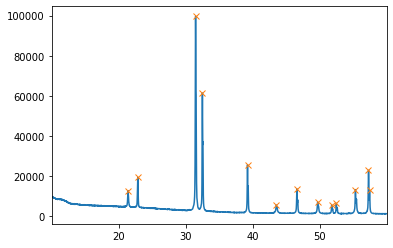

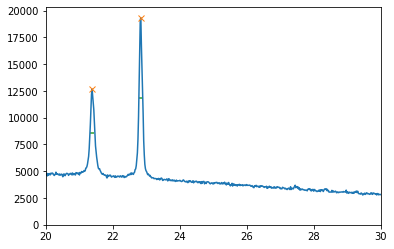

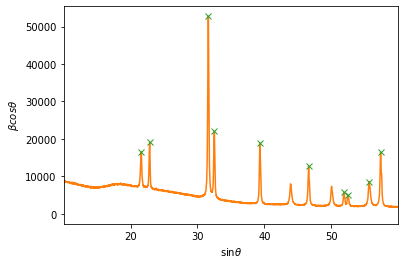

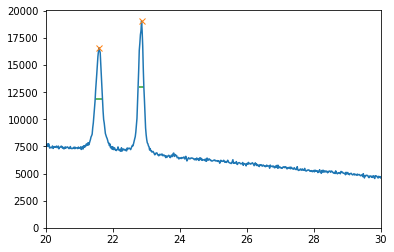

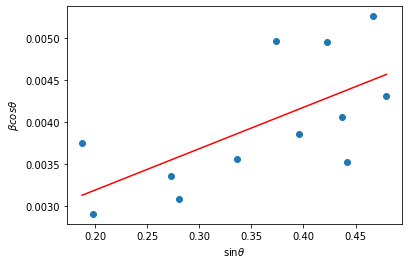

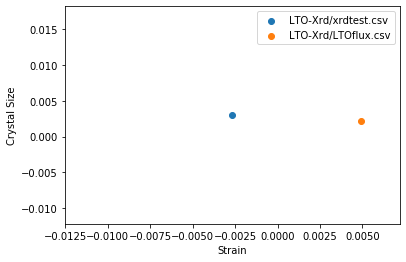

In [49]:
spectra = autoWH('.','PbTiO3-FZ-publication-cif.txt',reject=False,peakscale=0.05, threshold=0.1, background=0)